In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.patches import Ellipse
import heartpy as hp
import os
import pickle

In [2]:
def timedomain(rr):
    results = {}
    hr = 63000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 63000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results


def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx


def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2


def preprocessing(hrdata):
    sos = signal.butter(2, [0.3,7], 'bandpass', fs = 128, output='sos')
    filtered_BPF = signal.sosfilt(sos, hrdata)
    filtered_MA = np.convolve(filtered_BPF, np.ones(64)/64, mode='valid')
    filtered_BPF = filtered_BPF[63:]
    filtered_PPG = filtered_BPF - filtered_MA
    return filtered_PPG

def get_peaks(ppg_processed):
    diff_sig_2 = np.diff(ppg_processed) ## do
    peaks_2, _ = find_peaks(diff_sig_2, distance=100*(30/63), prominence=0.01)
    result = []
    peaks = []
    for i in range(len(peaks_2)):
        if diff_sig_2[peaks_2][i] > 40:
            result.append(peaks_2[i])
            peaks.append(diff_sig_2[peaks_2][i])
            
    return result, peaks, diff_sig_2
            
def get_NNIntervals(ppg):
    result, peaks, _ = get_peaks(ppg)
    NN_intervals = []
    for i in range(len(result)-1):
        nn = result[i+1] - result[i]
        NN_intervals.append(nn)
    
    return NN_intervals


def visualization(title, ppg):
    plt.figure(figsize=(20,8))
    plt.plot(ppg)
    plt.title(title, color="black")
    plt.tick_params(axis="both",colors="black")
    
def visualization_nn(title, diff_sig_2, peaks, positions):
    plt.figure(figsize=(20,8))
    plt.plot(diff_sig_2)
    plt.scatter(peaks,positions, color="red")
    plt.title(title)
    plt.gca().set_xlim(0,8064)
    plt.show
    plt.savefig('/tmp/elias/emotion_recognition/testplot.png')


In [3]:
dir_list_ = os.listdir("/tmp/elias/emotion_recognition/data")
dir_list_.sort()
count = 0
dir_list = []
dir_list_.pop(0)

for i in range(22):
    dir_list.append(dir_list_[i])
labels_Valence = []
labels_Arousal = []
PPG_data = []

for file in dir_list:
    dat_file = '/tmp/elias/emotion_recognition/data/' + file
    with open(dat_file, 'rb') as f:
        Channel_data =pickle.load(f,encoding='latin1')
    data = Channel_data["data"]
    labels = Channel_data["labels"]
    for num_video in range(40):
        dataP = data[num_video,38]
        PPG_data.append(dataP[384:])
    for value in labels:
        if value[0] < 5:
            labels_Valence.append(0)
        if value[0] >= 5:
            labels_Valence.append(1)
        if value[1] < 5:
            labels_Arousal.append(0)
        if value[1] >= 5:
            labels_Arousal.append(1)

count = 0
window = 1280
preprocessed = []
segmented = []
labels_Vdata = []
labels_Adata = []

for PPG in PPG_data:
    preprocessed_d = preprocessing(PPG)
    preprocessed.append(preprocessed_d)
    
for PPG in PPG_data:
    temp = []
    for i in range(window, len(PPG)):
        temp.append(PPG[i-window:i])
    labels_Vdata.append(labels_Valence[count])
    labels_Adata.append(labels_Arousal[count])
    segmented.append(temp)
    count = count+1

print(len(PPG_data))
print(len(preprocessed))
print(len(PPG_data[0]))

880
880
7680


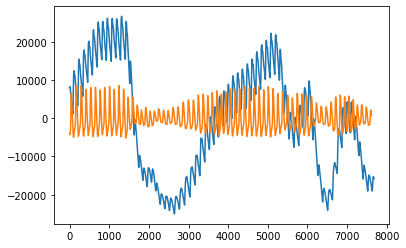

In [4]:
plt.plot(PPG_data[0])
plt.plot(preprocessed[0])

In [5]:
#init 가능한가요?
def take_features(segmented_data):
    
    df = pd.DataFrame(columns=[
    'meanNN', 'medianNN', 'NN50','pNN50', 'RMSSD',
    'VLF_a','LF_a', 'HF_a', 'Total_a',
    'VLF_h', 'LF_h', 'HF_h',
    'VLF_p', 'LF_p', 'HF_p',
    'LF_n', 'HF_n','LFHF'
    ])
    
    rr_2 = get_NNIntervals(segmented_data)
    # frequency
    x_2 = np.cumsum(rr_2)/ 100.0
    f_2 = interp1d(x_2, rr_2, kind='cubic',fill_value="extrapolate")
    fs = 4.0
    steps = 1 / fs
    xx_2 = np.arange(1, np.max(x_2), steps)

    rr_interpolated = f_2(xx_2)
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)

    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)

    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])

    total_power = vlf + lf + hf

    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)

    new_data = {
        'meanNN': np.mean(rr_2),
        'medianNN': np.median(rr_2), 
        'NN50' : np.sum(np.abs(np.diff(rr_2)) >= 50)*1 ,
        'pNN50' : 100 * np.sum((np.abs(np.diff(rr_2)) >= 50)*1) / len(rr_2), 
        'RMSSD' : np.sqrt(np.mean(np.square(np.diff(rr_2)))),
        'VLF_a' : vlf,'LF_a' : lf,'HF_a' : hf,'Total_a' : total_power,
        'VLF_h' : peak_vlf,'LF_h' : peak_lf, 'HF_h' : peak_hf, 
        'VLF_p' : vlf/total_power,'LF_p' : lf/total_power,
        'HF_p' : hf/total_power,'LF_n' : lf_nu,'HF_n' : hf_nu,'LFHF' : lf/hf
    }
    
    return new_data

In [6]:
index = 0
data_features = []

for video in segmented:
    df = pd.DataFrame(columns=[
        'meanNN', 'medianNN', 'NN50','pNN50', 'RMSSD',
        'VLF_a','LF_a', 'HF_a', 'Total_a',
        'VLF_h', 'LF_h', 'HF_h',
        'VLF_p', 'LF_p', 'HF_p',
        'LF_n', 'HF_n','LFHF'
        ])

    df_temp = pd.DataFrame(columns=[
            'meanNN', 'medianNN', 'NN50','pNN50', 'RMSSD',
            'VLF_a','LF_a', 'HF_a', 'Total_a',
            'VLF_h', 'LF_h', 'HF_h',
            'VLF_p', 'LF_p', 'HF_p',
            'LF_n', 'HF_n','LFHF'
            ])

    for segmented_data in video:
        df_features = take_features(segmented_data)
        df_temp = df_temp.append(df_features, ignore_index=True)

    df = df.append(df_temp, ignore_index=True)
    df.to_csv(f'features_2/{index}vid_{labels_Valence[index]}_{labels_Arousal[index]}.csv')
    print(index)
    index = index + 1

/home/sselab/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 40, using nperseg = 40
  .format(nperseg, input_length))
/home/sselab/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 45, using nperseg = 45
  .format(nperseg, input_length))
/home/sselab/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 44, using nperseg = 44
  .format(nperseg, input_length))
/home/sselab/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 39, using nperseg = 39
  .format(nperseg, input_length))
/home/sselab/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 43, using nperseg = 43
  .format(nperseg, input_length))
/home/ssel

0


/home/sselab/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 37, using nperseg = 37
  .format(nperseg, input_length))
/home/sselab/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 38, using nperseg = 38
  .format(nperseg, input_length))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


/home/sselab/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 36, using nperseg = 36
  .format(nperseg, input_length))


25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293

/home/sselab/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 35, using nperseg = 35
  .format(nperseg, input_length))
/home/sselab/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 34, using nperseg = 34
  .format(nperseg, input_length))


460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709


/home/sselab/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 32, using nperseg = 32
  .format(nperseg, input_length))


864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879


In [7]:
print(len(data_features))

0


In [8]:
print(len(segmented))

880


In [9]:
print(len(data_features))

0


#init 가능한가요?
def takee_features(segmented_data):
    
    rr_2 = get_NNIntervals(segmented_data)
    # frequency
    x_2 = np.cumsum(rr_2)/ 100.0
    f_2 = interp1d(x_2, rr_2, kind='cubic',fill_value="extrapolate")
    fs = 4.0
    steps = 1 / fs
    xx_2 = np.arange(1, np.max(x_2), steps)
    rr_interpolated = f_2(xx_2)
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)

    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)

    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])

    total_power = vlf + lf + hf

    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)

    new_data = {
        'meanNN': np.mean(rr_2),
        'medianNN': np.median(rr_2), 
        'NN50' : np.sum(np.abs(np.diff(rr_2)) >= 50)*1 ,
        'pNN50' : 100 * np.sum((np.abs(np.diff(rr_2)) >= 50)*1) / len(rr_2), 
        'RMSSD' : np.sqrt(np.mean(np.square(np.diff(rr_2)))),
        'VLF_a' : vlf,'LF_a' : lf,'HF_a' : hf,'Total_a' : total_power,
        'VLF_h' : peak_vlf,'LF_h' : peak_lf, 'HF_h' : peak_hf, 
        'VLF_p' : vlf/total_power,'LF_p' : lf/total_power,
        'HF_p' : hf/total_power,'LF_n' : lf_nu,'HF_n' : hf_nu,'LFHF' : lf/hf
    }
    
#     print(new_data)
    
    return new_data

df = pd.DataFrame(columns=[
        'meanNN', 'medianNN', 'NN50','pNN50', 'RMSSD',
        'VLF_a','LF_a', 'HF_a', 'Total_a',
        'VLF_h', 'LF_h', 'HF_h',
        'VLF_p', 'LF_p', 'HF_p',
        'LF_n', 'HF_n','LFHF'
        ])

df_temp = pd.DataFrame(columns=[
        'meanNN', 'medianNN', 'NN50','pNN50', 'RMSSD',
        'VLF_a','LF_a', 'HF_a', 'Total_a',
        'VLF_h', 'LF_h', 'HF_h',
        'VLF_p', 'LF_p', 'HF_p',
        'LF_n', 'HF_n','LFHF'
        ])

for segmented_data in video:
    df_features = take_features(segmented_data)
    df_temp = df_temp.append(df_features, ignore_index=True)

df = df.append(dff_temp, ignore_index=True)
df.to_csv(f'features/{index}vid_{labels_Valence[index]}_{labels_Arousal[index]}.csv')
print(index)
index = index + 1

In [10]:
print(type(df_features))

<class 'dict'>


In [11]:
print(df)

          meanNN  medianNN  NN50  pNN50      RMSSD  VLF_a  LF_a       HF_a  \
0     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
1     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
2     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
3     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
4     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
...          ...       ...   ...    ...        ...    ...   ...        ...   
6395  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   
6396  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   
6397  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   
6398  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   
6399  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   

        Total_a  VLF_h      LF_h      HF_h  VLF_p  LF_p  HF_p  

In [12]:
print(len(df))

6400


In [13]:
print(len(df_temp))

6400


In [14]:
print(df)

          meanNN  medianNN  NN50  pNN50      RMSSD  VLF_a  LF_a       HF_a  \
0     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
1     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
2     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
3     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
4     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
...          ...       ...   ...    ...        ...    ...   ...        ...   
6395  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   
6396  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   
6397  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   
6398  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   
6399  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   

        Total_a  VLF_h      LF_h      HF_h  VLF_p  LF_p  HF_p  

In [15]:
print(df_temp)

          meanNN  medianNN  NN50  pNN50      RMSSD  VLF_a  LF_a       HF_a  \
0     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
1     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
2     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
3     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
4     106.363636     108.0   0.0    0.0   6.678323    0.0   0.0   6.573447   
...          ...       ...   ...    ...        ...    ...   ...        ...   
6395  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   
6396  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   
6397  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   
6398  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   
6399  109.818182     109.0   0.0    0.0  10.616026    0.0   0.0  45.385292   

        Total_a  VLF_h      LF_h      HF_h  VLF_p  LF_p  HF_p  